# 一、数据预处理


# 1.1 环境准备 

In [ ]:
!pip install -U openmim
!mim install mmengine

In [ ]:
! mim uninstall mmcv
! mim uninstall mmcv-full

In [ ]:
!mim install 'mmcv>=2.0.0rc4'

In [ ]:
!pip install opencv-python pillow matplotlib seaborn tqdm 'mmdet>=3.0.0rc1' -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
# 删掉原有的 mmtracking 文件夹（如有）
# !rm -rf mmsegmentation
# 从 github 上下载最新的 mmsegmentation 源代码
# !git clone https://github.com/open-mmlab/mmsegmentation.git -b dev-1.x

In [ ]:
# 进入主目录
import os
os.chdir('mmsegmentation')

In [ ]:
!pip install -v -e .

In [ ]:
# 检查 Pytorch
import torch, torchvision
print('Pytorch 版本', torch.__version__)
print('CUDA 是否可用',torch.cuda.is_available())

In [ ]:
# 检查 mmcv
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('MMCV版本', mmcv.__version__)
print('CUDA版本', get_compiling_cuda_version())
print('编译器版本', get_compiler_version())

In [ ]:
# 检查 mmsegmentation
import mmseg
from mmseg.utils import register_all_modules
from mmseg.apis import inference_model, init_model
print('mmsegmentation版本', mmseg.__version__)

## 1.2 import

In [ ]:
import os
import numpy as np
from PIL import Image
import os.path as osp
from tqdm import tqdm
import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

## 1.3 下载数据

In [ ]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

## 1.4 样本转换

In [ ]:
# 数据集图片和标注路径
data_root = '/openbayes/home/PASCAL_VOC2007/VOCdevkit/VOC2007'
img_dir = 'JPEGImages'
ann_dir = 'SegmentationClass'
classes = ('背景(null)','飞机(aeroplane)','自行车(bicycle)','鸟(bird)','船(boat)','瓶子(bottle)','大巴(bus)','汽车(car)','猫(cat)','椅子(chair)','奶牛(cow)','餐桌(diningtable)','狗(dog)','马(horse)','摩托车(motorbike)','人(person)','盆栽(pottedplant)','羊(sheep)','沙发(sofa)','火车(train)','显示器(tvmonitor)')
palette = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],[128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0],[192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0],[128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]]

In [ ]:
for file in tqdm(mmengine.scandir(osp.join(data_root, ann_dir), suffix='.mat')):
    mat=loadmat(os.path.join(data_root,ann_dir,file))
    seg_map = mat['groundtruth'].astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.mat', '.png')))
    

## 1.5 样本验证

In [ ]:
import matplotlib.patches as mpatches

image_name = '000032'
img_origin = Image.open(os.path.join(data_root,img_dir,image_name+'.jpg'))
img_seg = Image.open(os.path.join(data_root,ann_dir,image_name+'.png'))

figure = plt.figure(figsize=(8, 6))
ax = figure.add_subplot(1, 2, 1)
ax.imshow(np.array(img_origin.convert('RGB')))
ax = figure.add_subplot(1, 2, 2)
ax.imshow(np.array(img_seg.convert('RGB')))

# 图例小块
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(20)]
# 图例
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

## 1.6 划分测试集合验证集

In [ ]:
# 随机划分训练集和验证集
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

# 二、训练模型

## 2.1 修改数据集类

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

## 2.2 修改config配置文件

In [ ]:
# 下载 config 文件 和 预训练模型checkpoint权重文件
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [ ]:
from mmengine import Config
cfg = Config.fromfile('/openbayes/home/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
#cfg.model.pretrained = '/openbayes/home/resnetv1c50_8xb32_in1k_20220214-3343eccd.pth'
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.num_classes = 20

cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.num_classes = 20

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=(256,256), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.batch_size = 8
cfg.train_dataloader.num_workers = 4
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'ImageSets/Segmentation/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'ImageSets/Segmentation/trainval.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = '/openbayes/home/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/pascal2007'

# 训练迭代次数
cfg.train_cfg.max_iters = 4000
# 评估模型间隔
cfg.train_cfg.val_interval = 4000
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1000

# # 随机数种子
cfg['randomness'] = dict(seed=0)

## 2.3 执行训练

In [ ]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

In [ ]:
runner.train()

# 三、验证模型

In [11]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [50]:
# 初始化模型
checkpoint_path = '/openbayes/home/work_dirs/pascal2007/iter_2000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: /openbayes/home/work_dirs/pascal2007/iter_2000.pth


In [57]:
# 载入测试图像
#img_path = '/openbayes/home/crafts.png'
img_path = '/openbayes/home/PASCAL_VOC2007/VOCdevkit/VOC2007/JPEGImages/000733.jpg'

img = mmcv.imread(img_path)


In [58]:
# 预测
result = inference_model(model, img)

{0, 14, 15}


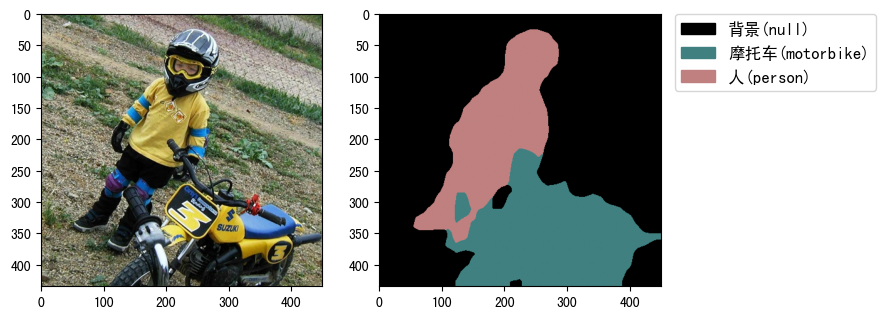

In [59]:
import matplotlib.patches as mpatches

# 可视化预测结果
opacity = 0 # 透明度，越大越接近原图
class_map = result.pred_sem_seg.data[0].detach().cpu().numpy()
seg_map = class_map.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))
visualization = show_result_pyplot(model, img, result, opacity=1.0, title='MMSeg', out_file='outputs/周杰伦.jpg')
img_origin = Image.open(img_path)

figure = plt.figure(figsize=(8, 6))
ax = figure.add_subplot(1, 2, 1)
ax.imshow(np.array(img_origin.convert('RGB')))
ax = figure.add_subplot(1, 2, 2)
ax.imshow(((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255)
# 图例
data = result.pred_sem_seg.data[0]
type_set = set()
dim0, dim1 = data.shape
for i in range(dim0):
    for j in range(dim1):
        typee = data[i][j].item()
        type_set.add(int(typee))
print(type_set)
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in type_set]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()